In [1]:
!pip install category_encoders
!pip install optuna
%pip install xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from category_encoders import CatBoostEncoder
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_parquet('~/Downloads/multisim_dataset.parquet')

df.info()
df.head()

Note: you may need to restart the kernel to use updated packages.
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9626 to 90423
Columns: 132 entries, telephone_number to target
dtypes: float64(111), int64(8), object(13)
memory usage: 10.1+ MB


,telephone_number,trf,age,gndr,tenure,age_dev,dev_man,device_os_name,dev_num,is_dualsim,...,val13_6,val14_6,val15_6,val16_6,val17_6,val18_6,val19_6,val20_6,val21_6,target
9626,iWBn_13aJO,J,50,M,6957.0,1263,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.56,0.00,0.00,60.0,7.0,0.0,1
34347,8JWaD2wYoQ,M,52,M,1041.0,125,Samsung,Android OS,2,1,...,206.536585,0.0,0.40,0.00,0.16,0.24,156.0,0.0,2.0,1
72797,sbPnQURi3j,A,49,U,7176.0,345,Samsung,Android OS,1,1,...,0.000000,0.0,0.25,2.35,0.00,0.25,241.0,87.0,4.0,1
68025,qOy-JlqPTl,M,49,M,4309.0,466,Samsung,Android OS,1,1,...,51.885746,0.0,0.00,0.00,0.00,0.00,299.0,142.0,80.0,1
31781,MNODhcb7h0,A,50,U,6999.0,695,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.80,0.00,0.00,121.0,96.0,0.0,1


In [2]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9626 to 90423
Columns: 132 entries, telephone_number to target
dtypes: float64(111), int64(8), object(13)
memory usage: 10.1+ MB


(10000, 132)

In [3]:
for col in df.columns:
    print(col)


telephone_number
trf
age
gndr
tenure
age_dev
dev_man
device_os_name
dev_num
is_dualsim
is_featurephone
is_smartphone
simcard_type
region
val2_1
val3_1
val4_1
val5_1
val6_1
val7_1
val8_1
val9_1
val10_1
val11_1
val12_1
val13_1
val14_1
val15_1
val16_1
val17_1
val18_1
val19_1
val20_1
val21_1
val2_2
val3_2
val4_2
val5_2
val6_2
val7_2
val8_2
val9_2
val10_2
val11_2
val12_2
val13_2
val14_2
val15_2
val16_2
val17_2
val18_2
val19_2
val20_2
val21_2
val2_3
val3_3
val4_3
val5_3
val6_3
val7_3
val8_3
val9_3
val10_3
val11_3
val12_3
val13_3
val14_3
val15_3
val16_3
val17_3
val18_3
val19_3
val20_3
val21_3
val2_4
val4_4
val5_4
val6_4
val7_4
val8_4
val9_4
val10_4
val11_4
val12_4
val13_4
val14_4
val15_4
val16_4
val17_4
val18_4
val19_4
val20_4
val21_4
val2_5
val4_5
val5_5
val6_5
val7_5
val8_5
val9_5
val10_5
val11_5
val12_5
val13_5
val14_5
val15_5
val16_5
val17_5
val18_5
val19_5
val20_5
val21_5
val2_6
val4_6
val5_6
val6_6
val7_6
val8_6
val9_6
val10_6
val11_6
val12_6
val13_6
val14_6
val15_6
val16_6
val17_6
val1

In [4]:
# Set the first column as index
df.set_index(df.columns[0], inplace=True)

# Keep columns from position 1 to 13 (the next 13 columns after index)
# plus the last column (position -1)
cols_to_keep = list(df.columns[0:13]) + [df.columns[-1]]

df = df[cols_to_keep]
df.head()

,trf,age,gndr,tenure,age_dev,dev_man,device_os_name,dev_num,is_dualsim,is_featurephone,is_smartphone,simcard_type,region,target
telephone_number,,,,,,,,,,,,,,
iWBn_13aJO,J,50,M,6957.0,1263,Samsung,Android OS,1,1,0,1,None,GAKH,1
8JWaD2wYoQ,M,52,M,1041.0,125,Samsung,Android OS,2,1,0,1,4G,MASALLI,1
sbPnQURi3j,A,49,U,7176.0,345,Samsung,Android OS,1,1,0,1,4G,SAATLI,1
qOy-JlqPTl,M,49,M,4309.0,466,Samsung,Android OS,1,1,0,1,4G,BAKU,1
MNODhcb7h0,A,50,U,6999.0,695,Samsung,Android OS,1,1,0,1,4G,ASTARA,1


In [5]:
df.isna().sum()

trf                  0
age                 24
gndr                 0
tenure              26
age_dev             20
dev_man             20
device_os_name      20
dev_num             20
is_dualsim           0
is_featurephone      0
is_smartphone        0
simcard_type       349
region              96
target               0
dtype: int64

In [6]:
#We will deal with missing values in pipeline (unless they are in the target column, then we should drop them)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, iWBn_13aJO to fcvlu4pk-Q
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trf              10000 non-null  object 
 1   age              9976 non-null   object 
 2   gndr             10000 non-null  object 
 3   tenure           9974 non-null   float64
 4   age_dev          9980 non-null   object 
 5   dev_man          9980 non-null   object 
 6   device_os_name   9980 non-null   object 
 7   dev_num          9980 non-null   object 
 8   is_dualsim       10000 non-null  object 
 9   is_featurephone  10000 non-null  object 
 10  is_smartphone    10000 non-null  object 
 11  simcard_type     9651 non-null   object 
 12  region           9904 non-null   object 
 13  target           10000 non-null  int64  
dtypes: float64(1), int64(1), object(12)
memory usage: 1.1+ MB


In [8]:
df['dev_num'] = pd.to_numeric(df['dev_num'], errors='coerce').fillna(0).astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, iWBn_13aJO to fcvlu4pk-Q
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trf              10000 non-null  object 
 1   age              9976 non-null   object 
 2   gndr             10000 non-null  object 
 3   tenure           9974 non-null   float64
 4   age_dev          9980 non-null   object 
 5   dev_man          9980 non-null   object 
 6   device_os_name   9980 non-null   object 
 7   dev_num          10000 non-null  int64  
 8   is_dualsim       10000 non-null  object 
 9   is_featurephone  10000 non-null  object 
 10  is_smartphone    10000 non-null  object 
 11  simcard_type     9651 non-null   object 
 12  region           9904 non-null   object 
 13  target           10000 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 1.1+ MB


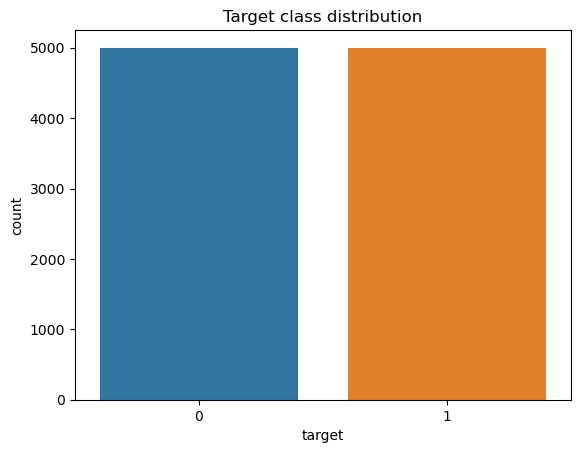

In [9]:
sns.countplot(data=df, x='target')
plt.title("Target class distribution")
plt.show()

#Shows if dataset is imbalanced. If strongly imbalanced, we might use ROC AUC instead of accuracy.

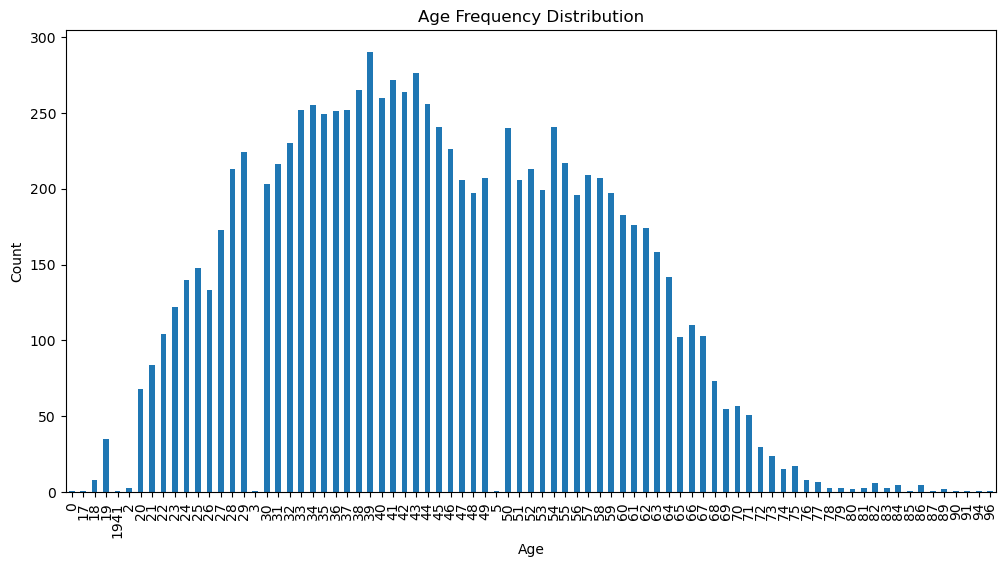

In [10]:
age_counts = df['age'].value_counts().sort_index()
age_counts.plot(kind='bar', figsize=(12,6))
plt.title('Age Frequency Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
#Detect outliers (negative or unrealistic ages), decide whether to bin age into groups.


Text(0.5, 1.0, 'Gender Distribution')

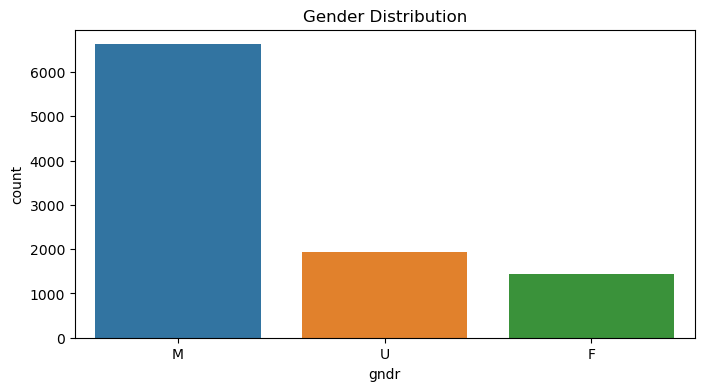

In [11]:
plt.figure(figsize=(8, 4))
sns.countplot(x='gndr', data=df) 
plt.title("Gender Distribution")
# Helps identify missing or 'Unknown' genders.

'Shows the popularity of each tariff plan. Useful for spotting class imbalance between categories\nand identifying if certain tariffs dominate the dataset'

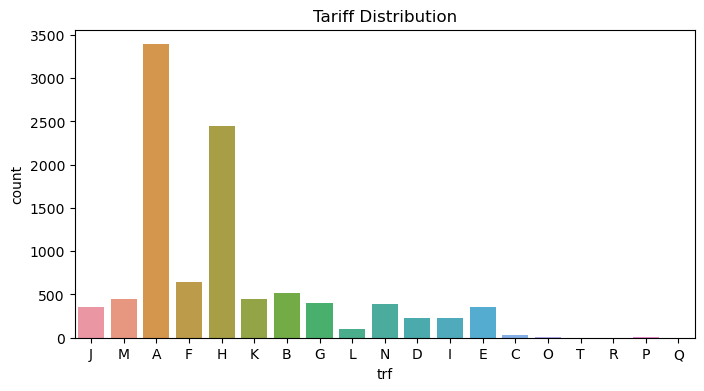

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(x='trf', data=df) 
plt.title("Tariff Distribution")
"""Shows the popularity of each tariff plan. Useful for spotting class imbalance between categories
and identifying if certain tariffs dominate the dataset"""

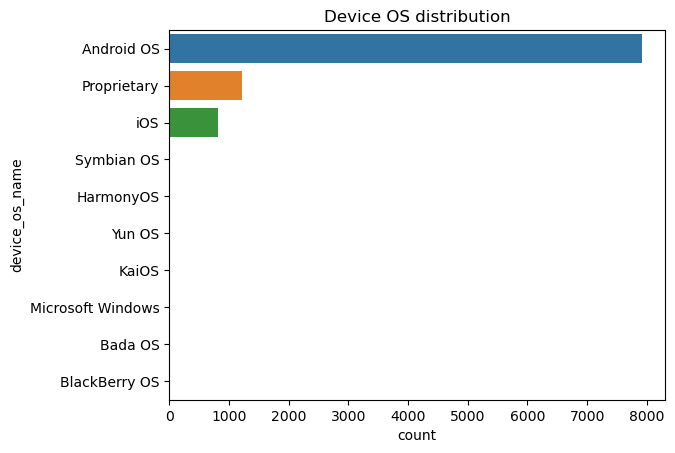

In [13]:
sns.countplot(data=df, y='device_os_name', order=df['device_os_name'].value_counts().index)
plt.title("Device OS distribution")
plt.show()


In [14]:
pd.crosstab(df['gndr'], df['target'], normalize='index') * 100
#Shows percentage of multi-SIM users for each gender; categorical features with clear separation can be strong predictors.

target,0,1
gndr,,
F,63.077985,36.922015
M,48.867754,51.132246
U,44.058121,55.941879


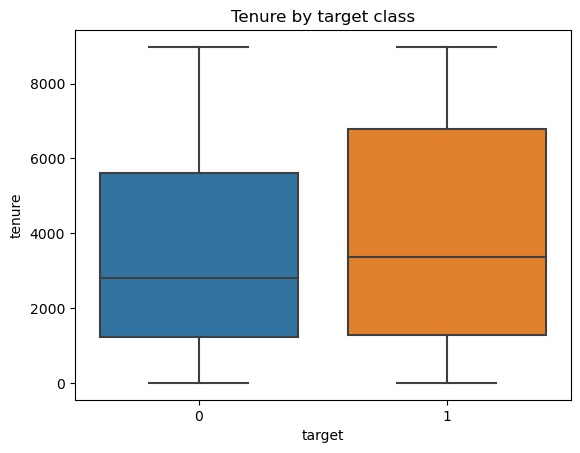

In [15]:
sns.boxplot(data=df, x='target', y='tenure')
plt.title("Tenure by target class")
plt.show()
# Compare average tenure between classes; could indicate loyalty effect.


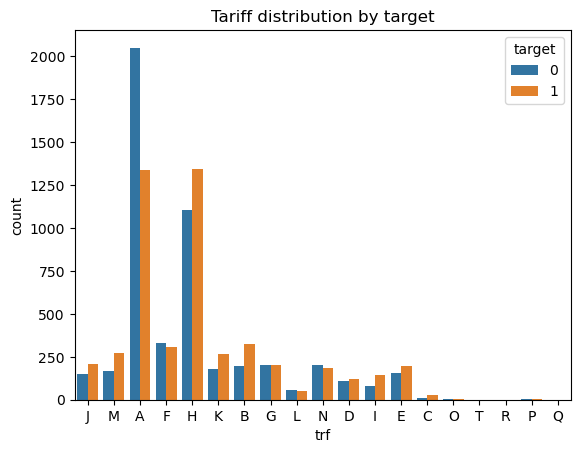

In [16]:
sns.countplot(data=df, x='trf', hue='target')
plt.title("Tariff distribution by target")
plt.show()
# Some tariffs might be preferred by multi-SIM users.

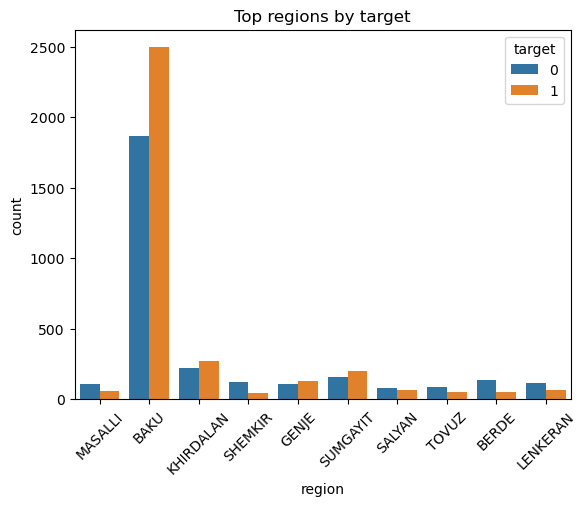

In [17]:
top_regions = df['region'].value_counts().nlargest(10).index
sns.countplot(data=df[df['region'].isin(top_regions)], x='region', hue='target')
plt.xticks(rotation=45)
plt.title("Top regions by target")
plt.show()
# Regional differences might signal different marketing or SIM usage patterns.

In [18]:
#Now we split train and test data
X = df.drop(columns="target")
y = df["target"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
df.nunique()

trf                  19
age                  81
gndr                  3
tenure             5586
age_dev            1983
dev_man              77
device_os_name       10
dev_num              25
is_dualsim            2
is_featurephone       2
is_smartphone         2
simcard_type          3
region               73
target                2
dtype: int64

In [20]:
binary_cols = ['is_dualsim', 'is_featurephone', 'is_smartphone']  
numeric_cols = ['tenure', 'dev_num'] 
onehot_cols = ['gndr', 'simcard_type']
catboost_cols = ['trf', 'age', 'age_dev', 'dev_man', 'device_os_name', 'region']


In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),       
    ('scaler', StandardScaler())                       
])

onehot_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder())
])

catboost_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CatBoostEncoder())
])

preprocessor = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_cols),
    ('catboost', catboost_transformer, catboost_cols),
    ('num', numeric_transformer, numeric_cols),
    ('bin', 'passthrough', binary_cols)  # keep binary cols as they are
])

model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(eval_metric='logloss', n_estimators=100))
])

model

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('catboost', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__min_child_weight': [1, 3, 5]
}


random_search = RandomizedSearchCV(
    model,                          
    param_distributions=param_dist, # parameters to try
    n_iter=30,                       # try 30 random combos
    scoring='f1',                    # metric to optimize
    cv=5,                            # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [28]:

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_  


model_params = {k.replace('model__', ''): v for k, v in best_params.items()}
tuned_model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(eval_metric='logloss', **model_params))
])


y_pred = best_model.predict(X_test)



Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [29]:
from sklearn.metrics import roc_auc_score
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.594
Precision:  0.5816993464052288
Recall:  0.7035573122529645
F1:  0.6368515205724508
ROC AUC Score:  0.5926693443855915


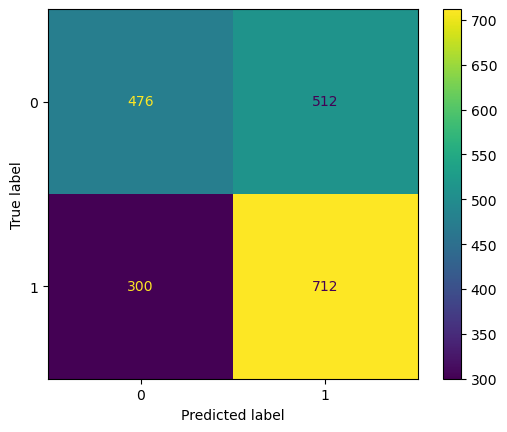

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()

In [26]:
"""
Higher number of False Positives (FP = 512) than False Negatives (FN = 300),meaning the model often 
predicts class 1 when the actual is class 0. Recall is higher than precision, indicating the model 
catches many actual positives but at the cost of more false alarms. Adjusting the decision threshold upward can 
help reduce FP at the expense of recall.
"""

'\nHigher number of False Positives (FP = 512) than False Negatives (FN = 300),meaning the model often \npredicts class 1 when the actual is class 0. Recall is higher than precision, indicating the model \ncatches many actual positives but at the cost of more false alarms. Adjusting the decision threshold upward can \nhelp reduce FP at the expense of recall.\n'

In [33]:
# Predict probabilities for positive class
y_proba = best_model.predict_proba(X_test)[:, 1]


import numpy as np
# Try different thresholds to see FP reduction
thresholds = np.arange(0.5, 0.91, 0.05)  # start at 0.5 default
print("Threshold | Precision | Recall | F1 | FP count")
for t in thresholds:
    preds_t = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_test, preds_t)
    FP = cm[0, 1]
    print(f"{t:.2f}      | {precision_score(y_test, preds_t):.3f}     | "
          f"{recall_score(y_test, preds_t):.3f}  | {f1_score(y_test, preds_t):.3f} | {FP}")


Threshold | Precision | Recall | F1 | FP count
0.50      | 0.582     | 0.704  | 0.637 | 512
0.55      | 0.603     | 0.607  | 0.605 | 405
0.60      | 0.619     | 0.461  | 0.529 | 288
0.65      | 0.658     | 0.307  | 0.419 | 162
0.70      | 0.675     | 0.168  | 0.269 | 82
0.75      | 0.734     | 0.068  | 0.125 | 25
0.80      | 0.576     | 0.019  | 0.036 | 14
0.85      | 0.750     | 0.003  | 0.006 | 1
0.90      | 0.000     | 0.000  | 0.000 | 0


/Users/nurayismayilli/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [34]:
'''Raising threshold from 0.50 to ~0.60 reduces False Positives significantly (from 508 down to ~295) 
while keeping a moderate recall. 
Choose threshold based on application needs:
high precision → fewer false positives (can be used in spam filters),
high recall → fewer missed positives (can be used in medical field).
'''

'Raising threshold from 0.50 to ~0.60–0.65 reduces False Positives significantly (from 508 down to ~295) \nwhile keeping a moderate recall. \nChoose threshold based on application needs:\nhigh precision → fewer false positives (can be used in spam filters),\nhigh recall → fewer missed positives (can be used in medical field).\n'

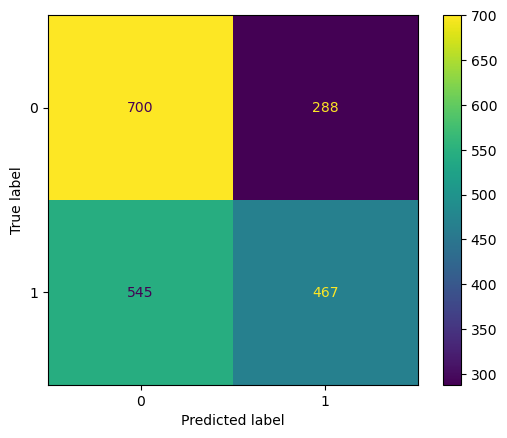

In [36]:
best_threshold = 0.60
y_pred_adj = (y_proba >= best_threshold).astype(int)
cm_adj = confusion_matrix(y_test, y_pred_adj)

ConfusionMatrixDisplay(confusion_matrix=cm_adj, display_labels=[0, 1]).plot()

In [38]:
xgb_model = best_model.named_steps['model']
importances = xgb_model.feature_importances_

feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

for name, score in zip(feature_names, importances):
    print(f"{name}: {score:.4f}")


onehot__gndr_F: 0.1020
onehot__gndr_M: 0.0367
onehot__gndr_U: 0.0438
onehot__simcard_type_3G: 0.0904
onehot__simcard_type_4G: 0.0667
onehot__simcard_type_unknown: 0.0477
onehot__simcard_type_None: 0.0340
catboost__0: 0.0604
catboost__1: 0.0456
catboost__2: 0.0390
catboost__3: 0.0433
catboost__4: 0.0453
catboost__5: 0.0722
num__tenure: 0.0576
num__dev_num: 0.0585
bin__is_dualsim: 0.0565
bin__is_featurephone: 0.0476
bin__is_smartphone: 0.0526
